# HW2
## Mahdi Sabbaghi(95109123)

# Part 1(PC Algtorithm):


At first, I've write some functions to help. Three functions for yielding the degree of a graph by the adjacency matrix(max degrree of vertices, degree of a vertex, and for delete a edge(make two elements zero in adjacency matrix)

In [1]:
total_degree <- function(m){
  n= dim(m)[1]
  max=0 
  for (i in c(1:n)){
      s= sum(m[i, ])
      if (s>max){
          max= s
      }
  }
  max
}
vertex_degree <- function(m, i){
  s= sum(m[i, ])
  s
}
delete_edge <- function(m, i, j){
  m[i, j]<-0
  m[j, i]<-0
  m
}

Then I define "correlation" function for "pearson" test and "partial_correlation". we now that by Fisher's Z transform:
$$z= \frac{1}{2} \log{ \frac{1+\rho} {1- \rho}}$$
and then:
$$ z \sqrt{n-m-3} \sim N(0, 1)$$
where n is the nuber of samples and m is the number of conditioned vectors.
so I used qnorm to have significance level of $\alpha$, (alpha in the code)
Note that because I have some problems for determining the v-structures I've defined print-correlation to find out which set makes a better d-separation.

In [29]:
correlation<- function(X, Y, alpha){
  n= length(X)
  rho= cor(X, Y)
  z <- 1/2*log((1+rho)/(1-rho))
  if (abs(z)*sqrt(n-3)> qnorm(1-alpha/2)){
    result<-0
  } else{
    result<-1
  }
  result
}

partial_correlation <- function(X, Y, Z, alpha){
  if (class(Z)== 'matrix'){
    m<- dim(Z)[2];
    n<- dim(Z)[1]; 
  } else{
    n <- length(Z)
    m<-1
  } 
  mm1 <- lm(X~Z)
  res1 <- mm1$residuals
  mm2 <- lm(Y~Z)
  res2 <- mm2$residuals
  rho <- cor(res1,res2)
  z <- 1/2*log((1+rho)/(1-rho))
  if (abs(z)*sqrt(n-m-3)> qnorm(1-alpha/2)){
    result<-0
  } else{
    result<-1
  }
  result
}

print_correlation <- function(X, Y, Z){
  if (class(Z)== 'matrix'){
    m<- dim(Z)[2];
    n<- dim(Z)[1]; 
  } else{
    n <- length(Z)
    m<-1
  } 
  mm1 <- lm(X~Z)
  res1 <- mm1$residuals
  mm2 <- lm(Y~Z)
  res2 <- mm2$residuals
  rho <- cor(res1,res2)
  z <- 1/2*log((1+rho)/(1-rho))
  result<- (abs(z)*sqrt(n-m-3))
  result
}


The "v_adjacency" have two major parts. In the first part, it considers a fully connected graph and determines the skeleton by checking every two nodes, whether they can be d-seperated by the neighbours or not.
In the second part, it searches for "unshielded triples: $(i, j ,k)$" and checking what causes the $i$ and $k$ to be detached(the problem was that some there were some unwanted sets that seperates the nodes! so instead of significant level I've chosen the set with the least $z \sqrt{n- m -3}$!) and then checking whether $j$ is in the set or not:
this function outputs two matrices, first the adjacency matrix of skeleton, and skleton with v-structures, two show it in $Mat[i, j]=2$ when we have an edge $i \to j$ and $Mat[i, j]=3$ when $j \to i$.

In [92]:
library(CombMSC)
library(ppcor)

v_adjacency<- function(X, pval, a){
    L<- dim(X)[1]
    n<- dim(X)[2]
    adjacency<- matrix(1, nrow= n, ncol = n)- diag(1, n)
    l<-0
    repeat{
      for (i in c(1:n)){
        if (vertex_degree(adjacency, i)<l+1){
          next
        }
        for (j in which(adjacency[i, ]!= 0)){
          if(l==0){
            if (correlation(X[, i], X[, j], alpha= a)==1){
              adjacency<- delete_edge(adjacency, i, j)
            }
          } else{
            if (j<n){   
              sets<- cbind(t(which(adjacency[i, 1:j-1]!=0)), t(which(adjacency[i,(j+1):n]!=0)+j))
            } else{
              sets<- which(adjacency[i, 1:n-1]!=0)
            }
            d<- length(sets)
            subs= subsets(d, l, sets)
            if (class(subs)== 'matrix'){
              k= dim(subs)[1]
              for (p in 1:k){
                index= subs[p, ]
                if (partial_correlation(X[, i], X[, j], X[ ,index], alpha= a)==1){
                  adjacency<- delete_edge(adjacency, i, j)
                  break
                }
              }
            } else{
              if (partial_correlation(X[, i], X[, j], X[, subs], alpha= a)==1){
                  adjacency<- delete_edge(adjacency, i, j)
                  break
              }  
            }
          }
        }
      }
      l<- l+1
      if (total_degree(adjacency)<l+1){
        break
      }
    }

    adj_v= adjacency

    for (i in c(1:n)){
        for (j in which(adjacency[i, ]!= 0)){
            for (k in which(adjacency[j, ]!= 0)){
                if (k!= i & adjacency[i, k]==0){
                    l=0
                    repeat{
                        if(l==0){
                            if (correlation(X[, i], X[, k], alpha= a)==1){
                                set= c()
                                break
                            }
                            } else{
                                min_sig=100
                                if (k<n){   
                                    sets<- cbind(t(which(adjacency[i, 1:k-1]!=0)), t(which(adjacency[i,(k+1):n]!=0)+k))
                                } else{
                                sets<- which(adjacency[i, 1:n-1]!=0)
                                }
                                d<- length(sets)
                                subs= subsets(d, l, sets)
                                if (class(subs)== 'matrix'){
                                  t= dim(subs)[1]
                                  for (p in 1:t){
                                    index= subs[p, ]
                                    if (pcor.test(X[, i], X[, k], X[ ,index])$p.value > pval & print_correlation(X[, i], X[, k], X[, index])< min_sig){
                                      set= index
                                      min_sig= print_correlation(X[, i], X[, k], X[, index])
                                    }
                                  }
                                } else{
                                  if (pcor.test(X[, i], X[, k], X[, subs])$p.value > pval & print_correlation(X[, i], X[, k], X[, subs])< min_sig){
                                      set= subs
                                      min_sig= print_correlation(X[, i], X[, k], X[, subs]) 
                                  }  
                                }
                          }
                        l<- l+1
                        if (total_degree(adjacency)<l+1){
                            break
                        }
                    }
                    if (!(j %in% set)){
                        adj_v[i, j]= 2
                        adj_v[j, i]= 3
                        adj_v[k, j]= 2
                        adj_v[j, k]= 3
                    }
                }
            }
        }
    }
    return(list(m1= adjacency, m2= adj_v))
}

# Meek rules:
As we have in Meek rules:
<img src="first.jpg" alt= "drawing" width="400" title="Meek's rules" />
so by using them I've searched by four nested loops for every structure like them:

In [108]:
Meek_rule<- function(adj){
    n= dim(adj)[1]
    for (i in c(1:n)){
        for (j in which(adj[i, ]== 2)){
            for (k in which(adj[j, ]== 1)){
                if (k!= i & adj[i, k]==0){
                    adj[j, k]= 2
                    adj[k, j]= 3
                }
            }
        }
    }
    
    for (i in c(1:n)){
        for (j in which(adj[i, ]== 2)){
            for (k in which(adj[j, ]== 2)){
                if (k!= i & adj[i, k]==1){
                    adj[i, k]= 2
                    adj[k, i]= 3
                }
            }
        }
    }
    
    for (i in c(1:n)){
        for (j in which(adj[i, ]== 2)){
            for (k in which(adj[j, ]== 3)){
                if (k!= i & adj[i, k]==0){
                    for (l in c(1:n)){
                        if (adj[i, l]==1 & adj[j, l]==1 & adj[k, l]==1){
                            adj[l, j]= 2
                            adj[j, l]= 3
                        }
                    }
                }
            }
        }
    }
    
    for (i in c(1:n)){
        for (j in which(adj[i, ]== 3)){
            for (k in which(adj[j, ]== 3)){
                if (k!= i & adj[i, k]==0){
                    for (l in c(1:n)){
                        if (adj[i, l]==1 & adj[j, l]==1 & adj[k, l]==1){
                            adj[l, i]= 2
                            adj[i, l]= 3
                        }
                    }
                }
            }
        }
    } 
    adj
}

# Part3(Testing the algorithm)
## a

As I said checking independency is hard!
So I make 100000 samples to have better results. note that I put $\alpha= 0.001$ for correlation and $pvalue = 0.1$ for pcor function by just examining

In [97]:
a= 0.001
pval= 0.1
L<-100000

X1<- as.numeric(1.2*rnorm(L, 0 ,1))
X2<- as.numeric(rnorm(L, 0 ,1))
X3<- as.numeric(2*X1 - 0.5*X2+ rnorm(L, 0 ,1))
X4<- as.numeric(0.4*X3+ rnorm(L, 0, 1))
X5<- as.numeric(0.8*X3 - 1*X4 + 0.6*rnorm(L, 0, 1))
X6<- as.numeric(X2+ X5+ rnorm(L, 0 , 1))
X<- cbind(X1, X2, X3, X4, X5, X6)

v_structures= v_adjacency(X, 0.1, 0.001)$m2; v_structures
cpdag= Meek_rule(v_structures)

0,0,2,0,0,0
0,0,2,0,0,2
3,3,0,1,1,0
0,0,1,0,1,0
0,0,1,1,0,2
0,3,0,0,3,0


So the cpDAg is:

In [98]:
cpdag

0,0,2,0,0,0
0,0,2,0,0,2
3,3,0,2,2,0
0,0,3,0,1,0
0,0,3,1,0,2
0,3,0,0,3,0


note that the edge between 4 and 5 remained undirected.

## b

by using "randomDAG" for generating a DAG and "rmvDAG" for generating data for it:

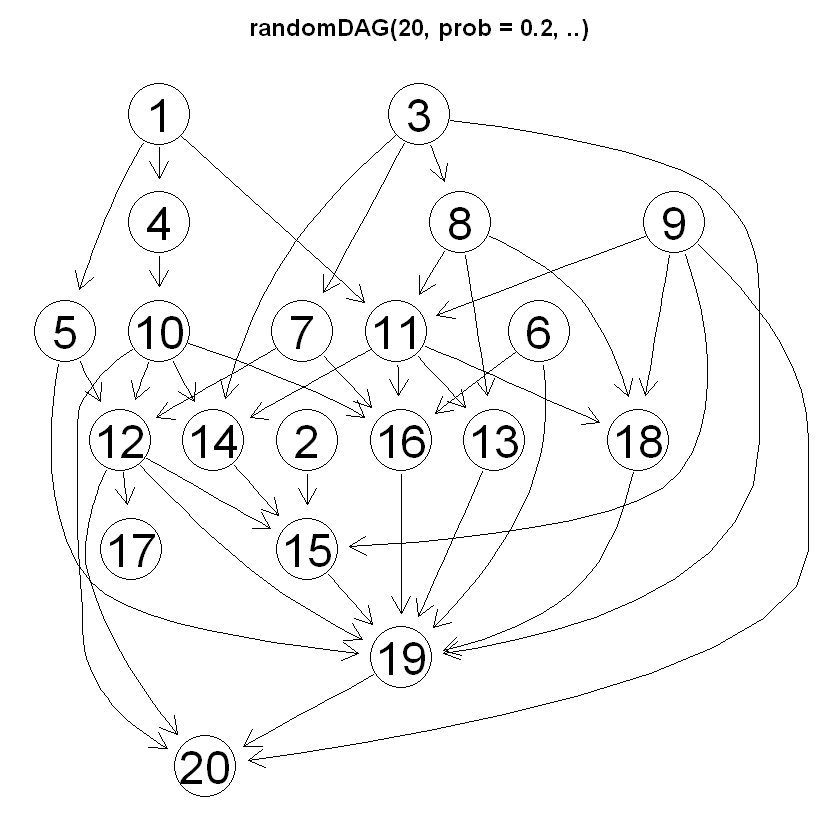

In [111]:
library(pcalg)
library(Rgraphviz)

p <- 20 
rDAG <- randomDAG(p, prob = 0.2, lB=0.1, uB=1)
 
plot(rDAG, main = "randomDAG(20, prob = 0.2, ..)")

n=50000
rDAG_Mat <- rmvDAG(n, rDAG, errDist="normal")

In [112]:
test_vstructures= v_adjacency(rDAG_Mat, 0.1, 0.001)$m2; test_vstructures
test_cpdag= Meek_rule(test_vstructures); test_cpdag

0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2
0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,3,2,0,2,0,2,0,0


0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2
0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,3,2,0,2,0,2,0,0


The result is not so good!
I think it's because of having no good function for checking independecy!